In [36]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np

### Import and Split Dataset

In [37]:
# Import MINST data
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype("float32") / 255.
x_test = x_test.astype("float32") / 255.

x_train.shape, y_train.shape

((60000, 28, 28), (60000,))

In [38]:
print("Categorical labels")
print(y_train[0:5])

# make labels one hot encoded
y_train = tf.one_hot(y_train, 10)
y_test = tf.one_hot(y_test, 10)

print("One hot encoded labels")
print(y_train[0:5])

Categorical labels
[5 0 4 1 9]
One hot encoded labels
tf.Tensor(
[[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]], shape=(5, 10), dtype=float32)


In [39]:
x_train = tf.reshape(x_train, [-1,28,28,1])  
x_train = tf.cast(x_train, 'float32') 

x_test = tf.reshape(x_test, [-1,28,28,1]) 
x_test = tf.cast(x_test, 'float32')

x_train.shape, x_test.shape

(TensorShape([60000, 28, 28, 1]), TensorShape([10000, 28, 28, 1]))

In [40]:
# Batching Data
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(100)
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(100)

### Building CNN Model

In [41]:
# Convolution Layer 1
w_conv1 = tf.Variable(tf.random.truncated_normal([5, 5, 1, 32], stddev=0.1, seed=0)) # 5x5 Kernel, 1 Feature input, 32 Feature outputs
b_conv1 = tf.Variable(tf.constant(0.1, shape=[32])) # Need 32 biases for 32 outputs

# Convolution Layer
def conv1(x):
    # Output is 32 [28x28] (32 different features of 28x28 pixel image)
    return(tf.nn.conv2d(x, w_conv1, strides=[1, 1, 1, 1], padding="SAME") + b_conv1)
    
# ReLU Activation Layer
def relu1(x): 
    return(tf.nn.relu(conv1(x)))

# Max Pooling Layer
def pool1(x):
    # Kernel size = 2x2 with 2 step Stride (No Overlapping)
    # Input size is 32 [28x28] and Output size is 32 [14x14]
    return tf.nn.max_pool(relu1(x), ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding="SAME")

In [42]:
# Convolution Layer 2
w_conv2 = tf.Variable(tf.random.truncated_normal([5, 5, 32, 64], stddev=0.1, seed=1)) # 5x5 Kernel, 32 Feature Input, 64 Feature Output
b_conv2 = tf.Variable(tf.constant(0.1, shape=[64])) #need 64 biases for 64 outputs

# Multiplication Layer (Add Weight and Bias)
def conv2(x): 
    # Output is 64 [14x14] (64 different features of 14x14 pixel image)
    return(tf.nn.conv2d(pool1(x), w_conv2, strides=[1, 1, 1, 1], padding="SAME") + b_conv2)

# ReLU Activation Layer
def relu2(x):  
    return tf.nn.relu(conv2(x))

# Max Pooling Layer
def pool2(x):  
    # Kernel size = 2x2 with 2 step Stride (No Overlapping)
    # Input size is 64 [14x14] and Output size is 64 [7x7]
    return(tf.nn.max_pool(relu2(x), ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding="SAME"))

In [43]:
# Fully Connected Layer
w_fc1 = tf.Variable(tf.random.truncated_normal([7*7*64, 1024], stddev=0.1, seed=2))
b_fc1 = tf.Variable(tf.constant(0.1, shape=[1024])) # need 1024 biases for 1024 outputs

# Flatten Layer
def flatten(x): 
    return tf.reshape(pool2(x), [-1, 7*7*64])

# Multiplication Layer (Add Weight and Bias)
def linear1(x): 
    return tf.matmul(flatten(x), w_fc1) + b_fc1

# ReLU Activation Layer
def relu3(x): 
    return tf.nn.relu(linear1(x))

# Dropout Layer
prob=0.5
def drop(x): 
    return tf.nn.dropout(relu3(x), prob)

In [44]:
# Softmax Fully Connected Layer
w_fc2 = tf.Variable(tf.random.truncated_normal([1024, 10], stddev=0.1, seed=2)) #1024 neurons
b_fc2 = tf.Variable(tf.constant(0.1, shape=[10])) # 10 possibilities for digits [0,1,2,3,4,5,6,7,8,9]

# Multiplication Layer (Add Weight and Bias)
def linear2(x): 
    return tf.matmul(drop(x), w_fc2) + b_fc2

# Softmax Layer
def CNN(x): 
    return tf.nn.softmax(linear2(x))

In [45]:
optimizer = tf.keras.optimizers.Adam(1e-4)
variables = [w_conv1, b_conv1, w_conv2, b_conv2, 
             w_fc1, b_fc1, w_fc2, b_fc2]

# Loss Function
def cross_entropy(y_label, y_pred):
    return (-tf.reduce_sum(y_label * tf.math.log(y_pred + 1.e-10)))

def train_step(x, y):
    with tf.GradientTape() as tape:
        current_loss = cross_entropy(y, CNN(x))
        grads = tape.gradient(current_loss, variables)
        optimizer.apply_gradients(zip(grads ,variables))
        return current_loss.numpy()

In [46]:
loss_values=[]
accuracies = []
epochs = 1

for i in range(epochs):
    j = 0
    # each batch has 50 examples
    for x_batch, y_batch in train_ds:
        j+=1
        current_loss = train_step(x_batch, y_batch)
            
    current_loss = cross_entropy(y_batch, CNN(x_batch)).numpy()
    loss_values.append(current_loss)
    correct_prediction = tf.equal(tf.argmax(CNN(x_batch), axis=1), tf.argmax(y_batch, axis=1))
    # Accuracy
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32)).numpy()
    accuracies.append(accuracy)
    print(f"Epoch: {str(i)} Batch: {str(j)} Loss: {str(current_loss)} Accuracy: {str(accuracy)}") 

Epoch: 0 Batch: 600 Loss: 31.991413 Accuracy: 0.98


### Evaluate Model

In [47]:
j = 0
acccuracies=[]
# Evaluate accuracy by batch and average for every 100th batch
for x_batch, y_batch in test_ds:
        j+=1
        correct_prediction = tf.equal(tf.argmax(CNN(x_batch), axis=1), tf.argmax(y_batch, axis=1))
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32)).numpy()
        accuracies.append(accuracy)
import numpy as np
print(f"Accuracy of entire set: {str(np.mean(accuracies))}")

Accuracy of entire set: 0.9388118


### Testing Sample Image

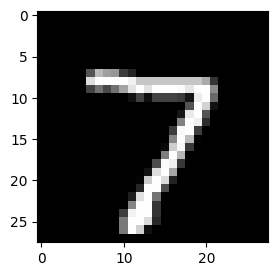

In [48]:
# Sample Image
sampleimage = tf.convert_to_tensor([x_test[0]], dtype=tf.float32)

plt.figure(1, figsize=(3,3))
plt.imshow(np.reshape(sampleimage,[28, 28]), cmap="gray")

C:\Users\ASUS\AppData\Local\Temp\ipykernel_11060\661504731.py:8: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  n_rows = np.math.ceil(filters / n_columns) + 1


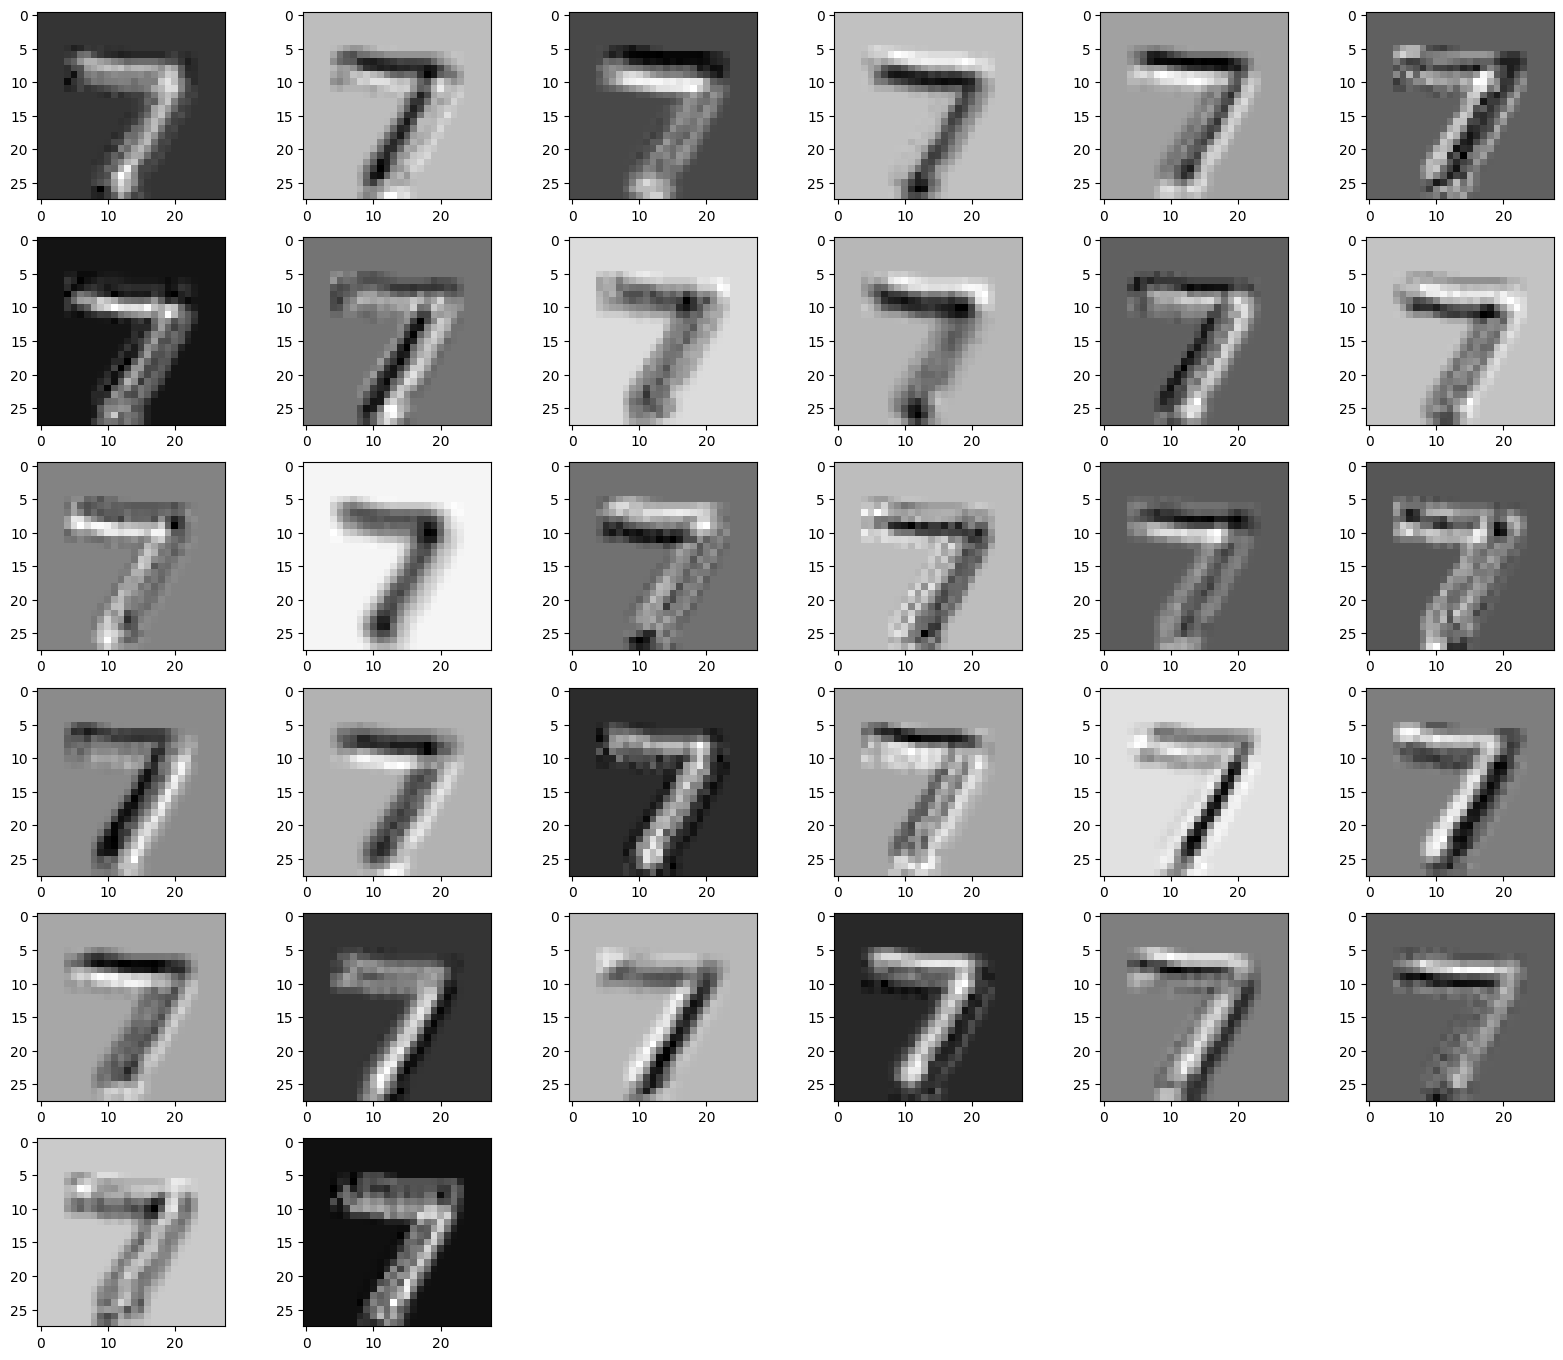

In [49]:
# First Convulation Image
keep_prob=1.0
ActivatedUnits = conv1(sampleimage)
                           
filters = ActivatedUnits.shape[3]
plt.figure(1, figsize=(20,20))
n_columns = 6
n_rows = np.math.ceil(filters / n_columns) + 1
for i in range(filters):
    plt.subplot(n_rows, n_columns, i+1)
    plt.imshow(ActivatedUnits[0,:,:,i], interpolation="nearest", cmap="gray")

C:\Users\ASUS\AppData\Local\Temp\ipykernel_11060\3708596712.py:6: DeprecationWarning: `np.math` is a deprecated alias for the standard library `math` module (Deprecated Numpy 1.25). Replace usages of `np.math` with `math`
  n_rows = np.math.ceil(filters / n_columns) + 1


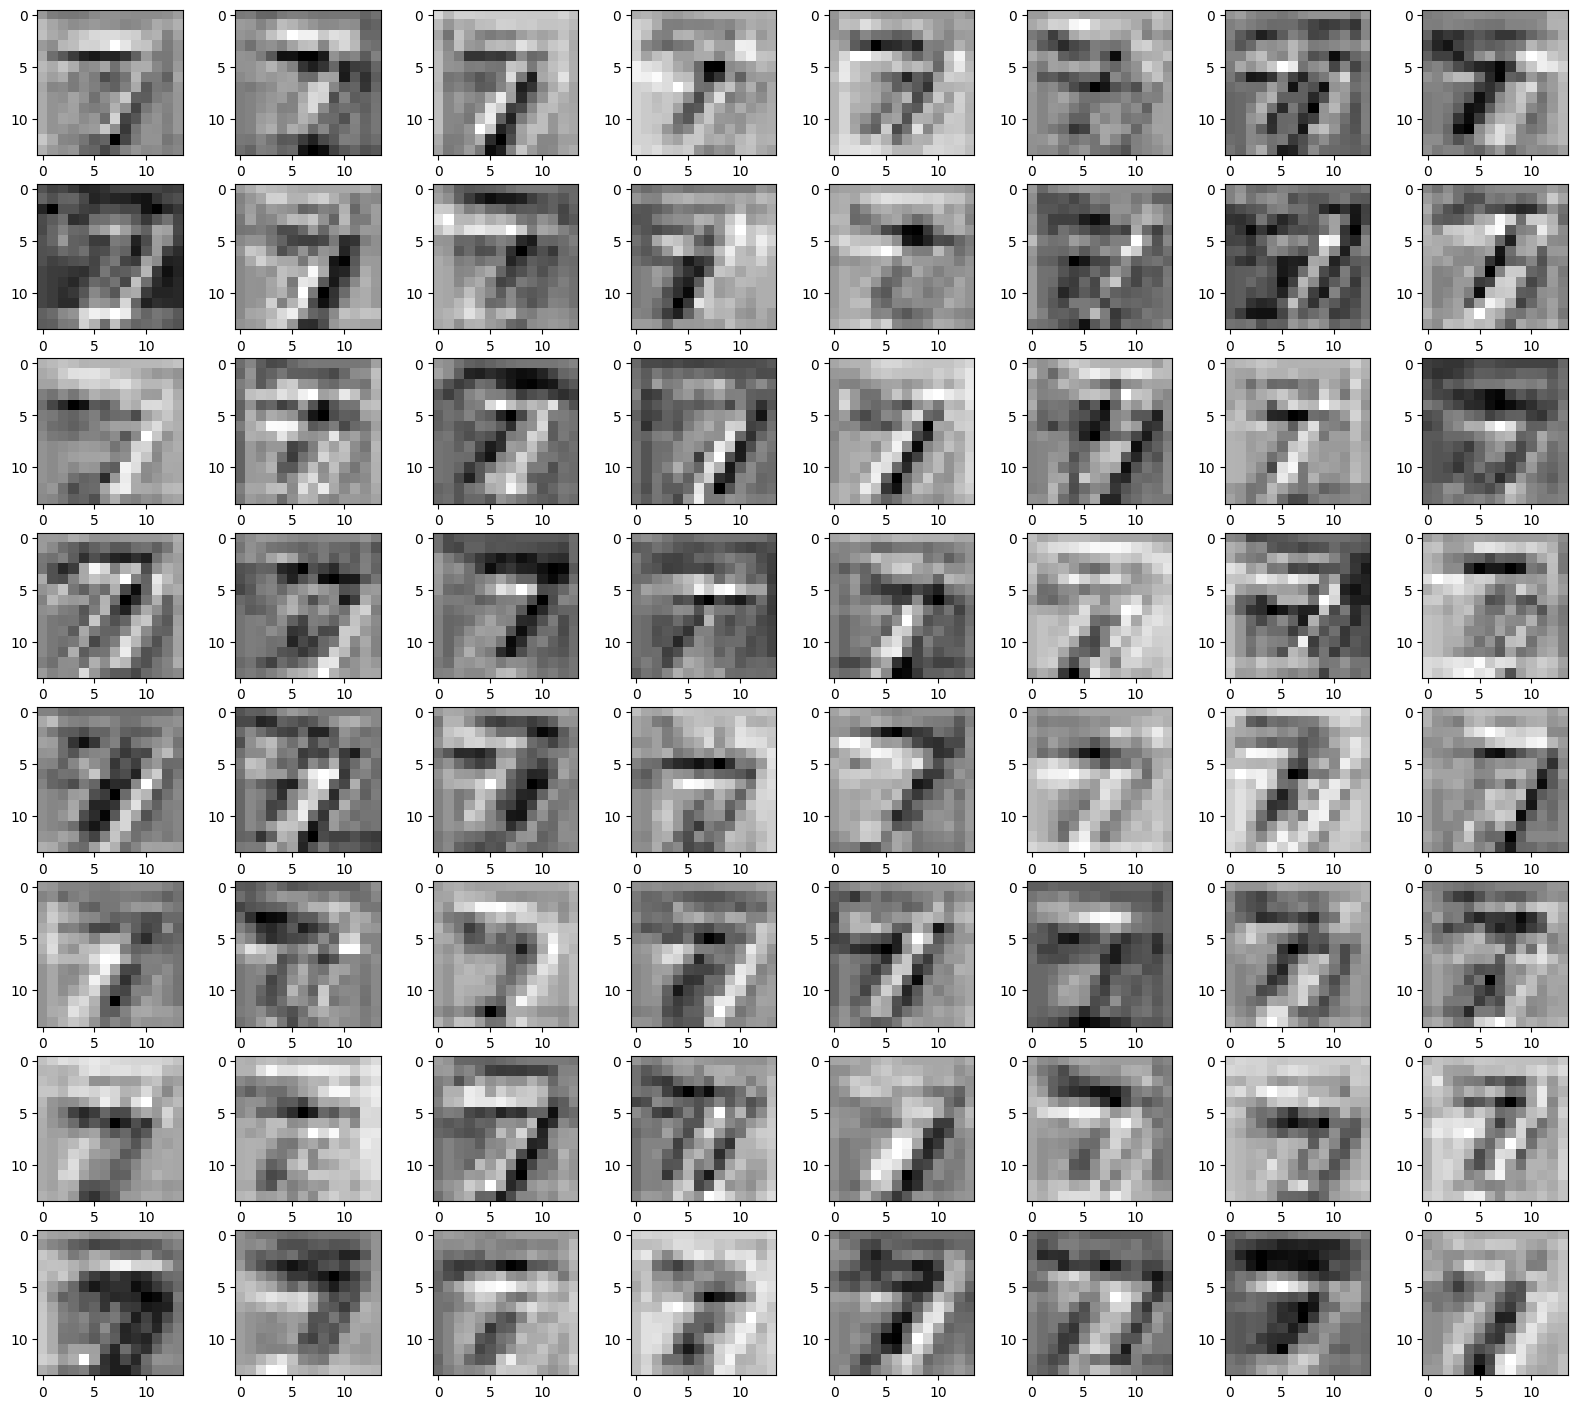

In [50]:
# Second Convulation Image
ActivatedUnits = conv2(sampleimage)
filters = ActivatedUnits.shape[3]
plt.figure(1, figsize=(20,20))
n_columns = 8
n_rows = np.math.ceil(filters / n_columns) + 1
for i in range(filters):
    plt.subplot(n_rows, n_columns, i+1)
    plt.imshow(ActivatedUnits[0,:,:,i], interpolation="nearest", cmap="gray")

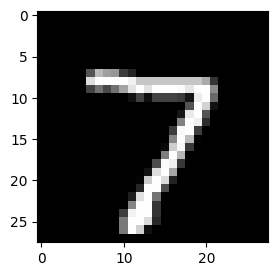

This is the number 7!


In [55]:
# Image Prediction
y_pred = CNN(sampleimage)
y_pred = tf.argmax(y_pred, axis=1).numpy()

plt.figure(1, figsize=(3,3))
plt.imshow(np.reshape(sampleimage,[28, 28]), cmap="gray")
plt.show()

print(f"This is the number {y_pred[0]}!")